<a href="https://colab.research.google.com/github/anantsaini473-jpg/colab-notebook/blob/main/music_genre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install streamlit --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 98.6 MB/s eta 0:00:00


In [2]:
!streamlit --version

Streamlit, version 1.52.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os, random, numpy as np, tensorflow as tf

# Fix random seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

# Create persistent project folder
project_dir = "/content/drive/MyDrive/music_genre_project"
os.makedirs(project_dir, exist_ok=True)

# Define file paths
MODEL_PATH = f"{project_dir}/music_genre_multimodal.h5"
ENCODER_PATH = f"{project_dir}/label_encoder.pkl"
SCALER_PATH = f"{project_dir}/scaler.pkl"


Mounted at /content/drive


In [ ]:
import os, glob, warnings
import numpy as np
import librosa
import librosa.feature as lf
import matplotlib.pyplot as plt
import kagglehub
import soundfile as sf
import audioread
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import scipy.signal
if not hasattr(scipy.signal, "hann"):
    from scipy.signal.windows import hann as _hann
    scipy.signal.hann = _hann

warnings.filterwarnings("ignore")

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

SR = 22050
DURATION = 30
N_SAMPLES = SR * DURATION

N_MELS = 128
HOP_LENGTH = 512
N_FFT = 2048
SPEC_TIME_FRAMES = int(np.ceil(N_SAMPLES / HOP_LENGTH))
IMG_HEIGHT, IMG_WIDTH = N_MELS, 1280
IMG_CHANNELS = 1

print("Environment ready — all imports successful.")
print("TensorFlow version:", tf.__version__)
print("NumPy version:", np.__version__)


Environment ready — all imports successful.
TensorFlow version: 2.19.0
NumPy version: 2.0.2


In [ ]:
root = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")
print("Dataset at:", root)

wav_dir_candidates = [
    os.path.join(root, "Data", "genres_original"),
    os.path.join(root, "genres_original"),
    root
]

wav_dir = None
for c in wav_dir_candidates:
    if os.path.isdir(c) and len(glob.glob(os.path.join(c, "*", "*.wav"))) > 0:
        wav_dir = c
        break

if wav_dir is None:
    raise RuntimeError("Could not find WAVs. Inspect the dataset structure printed above.")

all_files = sorted(glob.glob(os.path.join(wav_dir, "*", "*.wav")))

def is_readable_wav(path: str) -> bool:
    try:
        _ = sf.info(path)
        return True
    except Exception:
        try:
            with audioread.audio_open(path) as _ar:
                return True
        except Exception:
            return False

files = []
skipped = []
for f in all_files:
    if is_readable_wav(f):
        files.append(f)
    else:
        skipped.append(f)

genres = sorted({os.path.basename(os.path.dirname(f)) for f in files})

print(f" Readable WAV files: {len(files)}")
print(f" Skipped unreadable/mislabeled files: {len(skipped)}")
if skipped:
    print("Examples of skipped files:", skipped[:5])

print(f"Genres discovered ({len(genres)}): {genres}")

from collections import Counter
counts = Counter(os.path.basename(os.path.dirname(f)) for f in files)
print("Per-genre counts (kept):", dict(counts))
if len(files) == 0:
    raise RuntimeError("No readable audio files found after validation. Please check dataset integrity.")


Using Colab cache for faster access to the 'gtzan-dataset-music-genre-classification' dataset.
Dataset at: /kaggle/input/gtzan-dataset-music-genre-classification
 Readable WAV files: 999
 Skipped unreadable/mislabeled files: 1
Examples of skipped files: ['/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav']
Genres discovered (10): ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Per-genre counts (kept): {'blues': 100, 'classical': 100, 'country': 100, 'disco': 100, 'hiphop': 100, 'jazz': 99, 'metal': 100, 'pop': 100, 'reggae': 100, 'rock': 100}


In [ ]:

def extract_tabular_features(y, sr=SR):
    """Extract robust 1D numeric features from raw audio for ML/ANN classifiers."""
    S = np.abs(librosa.stft(y, n_fft=N_FFT, hop_length=HOP_LENGTH))
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS,
                                         n_fft=N_FFT, hop_length=HOP_LENGTH)
    logmel = librosa.power_to_db(mel + 1e-6)

    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S**2 + 1e-6),
                                sr=sr, n_mfcc=20)
    chroma = librosa.feature.chroma_stft(S=S, sr=sr)
    contrast = librosa.feature.spectral_contrast(S=S, sr=sr)
    centroid = librosa.feature.spectral_centroid(S=S, sr=sr)
    bandwidth = librosa.feature.spectral_bandwidth(S=S, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(S=S, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)

    try:
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    except Exception:
        tempo = 0.0

    def stats(a):
        a = np.asarray(a)
        return np.array([a.mean(), a.std(), np.median(a), a.min(), a.max()],
                        dtype=np.float32)

    def as1d(x):
        a = np.asarray(x, dtype=np.float32)
        if a.ndim == 0:
            return np.array([a], dtype=np.float32)
        return a.ravel()

    feat_vec = np.hstack([
        stats(logmel),
        as1d(mfcc.mean(axis=1)), as1d(mfcc.std(axis=1)),
        as1d(chroma.mean(axis=1)), as1d(chroma.std(axis=1)),
        as1d(contrast.mean(axis=1)), as1d(contrast.std(axis=1)),
        as1d(centroid.mean()), as1d(centroid.std()),
        as1d(bandwidth.mean()), as1d(bandwidth.std()),
        as1d(rolloff.mean()), as1d(rolloff.std()),
        as1d(zcr.mean()), as1d(zcr.std()),
        as1d(np.float32(tempo))
    ]).astype(np.float32)

    return feat_vec


def extract_spectrogram_image(y, sr=SR):
    """Generate normalized log-mel spectrogram image for CNN input."""
    mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_mels=N_MELS, n_fft=N_FFT,
        hop_length=HOP_LENGTH, power=2.0
    )
    logmel = librosa.power_to_db(mel + 1e-6)

    m = logmel.mean()
    s = logmel.std() + 1e-6
    logmel = (logmel - m) / s

    T = logmel.shape[1]
    if T >= IMG_WIDTH:
        start = (T - IMG_WIDTH) // 2
        img = logmel[:, start:start + IMG_WIDTH]
    else:
        pad_left = (IMG_WIDTH - T) // 2
        pad_right = IMG_WIDTH - T - pad_left
        img = np.pad(logmel, ((0, 0), (pad_left, pad_right)), mode="constant")

    img = img.astype(np.float32)[..., None]
    return img


cache_dir = "/kaggle/working/cached_features"
os.makedirs(cache_dir, exist_ok=True)

X_tab_cache = os.path.join(cache_dir, "X_tabular.npy")
X_img_cache = os.path.join(cache_dir, "X_spectrogram.npy")
y_cache = os.path.join(cache_dir, "y_labels.npy")

if all(os.path.exists(p) for p in [X_tab_cache, X_img_cache, y_cache]):
    print("✅ Found cached feature files, loading them...")
    X_tab = np.load(X_tab_cache)
    X_img = np.load(X_img_cache)
    y = np.load(y_cache, allow_pickle=True)
else:
    X_tab_list, X_img_list, y_list = [], [], []
    skipped = 0
    for i, f in enumerate(files):
        try:
            y_raw, _ = librosa.load(f, sr=SR, mono=True)
        except Exception as e:
            print(f"⚠️ Skipping {f} — load error: {e}")
            skipped += 1
            continue

        if len(y_raw) < N_SAMPLES:
            y_raw = np.pad(y_raw, (0, N_SAMPLES - len(y_raw)))
        else:
            y_raw = y_raw[:N_SAMPLES]

        tab = extract_tabular_features(y_raw, SR)
        img = extract_spectrogram_image(y_raw, SR)

        X_tab_list.append(tab)
        X_img_list.append(img)
        y_list.append(os.path.basename(os.path.dirname(f)))

        if (i + 1) % 100 == 0:
            print(f"Processed {i + 1}/{len(files)} | Skipped: {skipped}")

    X_tab = np.vstack(X_tab_list)
    X_img = np.stack(X_img_list, axis=0)
    y = np.array(y_list)

    np.save(X_tab_cache, X_tab)
    np.save(X_img_cache, X_img)
    np.save(y_cache, y)
    print(f"✅ Saved extracted features to {cache_dir}")

print("Tabular features:", X_tab.shape)
print("Spectrogram images:", X_img.shape)
print("Labels:", y.shape)



Processed 100/999 | Skipped: 0
Processed 200/999 | Skipped: 0
Processed 300/999 | Skipped: 0
Processed 400/999 | Skipped: 0
Processed 500/999 | Skipped: 0
Processed 600/999 | Skipped: 0
Processed 700/999 | Skipped: 0
Processed 800/999 | Skipped: 0
Processed 900/999 | Skipped: 0
✅ Saved extracted features to /kaggle/working/cached_features
Tabular features: (999, 92)
Spectrogram images: (999, 128, 1280, 1)
Labels: (999,)


In [ ]:
le = LabelEncoder()
y_enc = le.fit_transform(y)
n_classes = len(le.classes_)
print("Classes:", list(le.classes_))

X_tab_train, X_tab_val, X_img_train, X_img_val, y_train, y_val = train_test_split(
    X_tab, X_img, y_enc, test_size=0.2, random_state=SEED, stratify=y_enc
)

scaler = StandardScaler()
X_tab_train_s = scaler.fit_transform(X_tab_train)
X_tab_val_s = scaler.transform(X_tab_val)

print("Train shapes:", X_tab_train_s.shape, X_img_train.shape)
print("Val shapes:", X_tab_val_s.shape, X_img_val.shape)


Classes: [np.str_('blues'), np.str_('classical'), np.str_('country'), np.str_('disco'), np.str_('hiphop'), np.str_('jazz'), np.str_('metal'), np.str_('pop'), np.str_('reggae'), np.str_('rock')]
Train shapes: (799, 92) (799, 128, 1280, 1)
Val shapes: (200, 92) (200, 128, 1280, 1)


In [4]:
import joblib, os
from tensorflow.keras.models import load_model

if os.path.exists(MODEL_PATH):
    print("✅ Found saved model — loading it instead of retraining...")
    model = load_model(MODEL_PATH)
    le = joblib.load(ENCODER_PATH)
    scaler = joblib.load(SCALER_PATH)
else:
    print("⚙️ No saved model found — training a new one...")

    def build_multimodal_model(
        img_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
        tab_dim=X_tab_train_s.shape[1],
        n_classes=10
    ):
        img_in = layers.Input(shape=img_shape, name="img_input")
        x = layers.Conv2D(32, (3,3), strides=(1,1), padding="same", activation="relu")(img_in)
        x = layers.MaxPooling2D((2,2))(x)
        x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
        x = layers.MaxPooling2D((2,2))(x)
        x = layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
        x = layers.MaxPooling2D((2,2))(x)
        x = layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
        x = layers.GlobalAveragePooling2D()(x)
        img_branch = layers.Dense(128, activation="relu")(x)

        tab_in = layers.Input(shape=(tab_dim,), name="tab_input")
        y = layers.BatchNormalization()(tab_in)
        y = layers.Dense(256, activation="relu")(y)
        y = layers.Dropout(0.3)(y)
        y = layers.Dense(128, activation="relu")(y)
        tab_branch = layers.Dropout(0.2)(y)

        z = layers.Concatenate()([img_branch, tab_branch])
        z = layers.BatchNormalization()(z)
        z = layers.Dense(128, activation="relu")(z)
        z = layers.Dropout(0.3)(z)
        out = layers.Dense(n_classes, activation="softmax")(z)

        model = keras.Model(inputs=[img_in, tab_in], outputs=out)
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=1e-3),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )
        return model

    model = build_multimodal_model(
        img_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
        tab_dim=X_tab_train_s.shape[1],
        n_classes=n_classes
    )

    model.summary()

    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=6, mode="min", restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
        )
    ]

    EPOCHS = 30
    BATCH_SIZE = 16

    history = model.fit(
        {"img_input": X_img_train, "tab_input": X_tab_train_s},
        y_train,
        validation_data=({"img_input": X_img_val, "tab_input": X_tab_val_s}, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )

    # ===== ADD THIS SAVE BLOCK AT THE END =====
    print("💾 Saving model, encoder, and scaler to Drive...")
    model.save(MODEL_PATH)
    joblib.dump(le, ENCODER_PATH)
    joblib.dump(scaler, SCALER_PATH)
    print("✅ Saved all components successfully.")


✅ Found saved model — loading it instead of retraining...



Evaluating: Multimodal CNN+MLP
Accuracy: 0.2750 | F1 (macro): 0.2255
              precision    recall  f1-score   support

       blues     0.3333    0.0500    0.0870        20
   classical     0.1064    0.2500    0.1493        20
     country     0.3333    0.1000    0.1538        20
       disco     0.2308    0.1500    0.1818        20
      hiphop     0.4000    0.3000    0.3429        20
        jazz     0.3947    0.7500    0.5172        20
       metal     0.4222    0.9500    0.5846        20
         pop     0.1250    0.0500    0.0714        20
      reggae     0.1875    0.1500    0.1667        20
        rock     0.0000    0.0000    0.0000        20

    accuracy                         0.2750       200
   macro avg     0.2533    0.2750    0.2255       200
weighted avg     0.2533    0.2750    0.2255       200


==================== Summary ====================


,Model,Accuracy,F1 (macro)
0,Multimodal CNN+MLP,0.2750,0.2255



🏆 Best performing classifier: Multimodal CNN+MLP


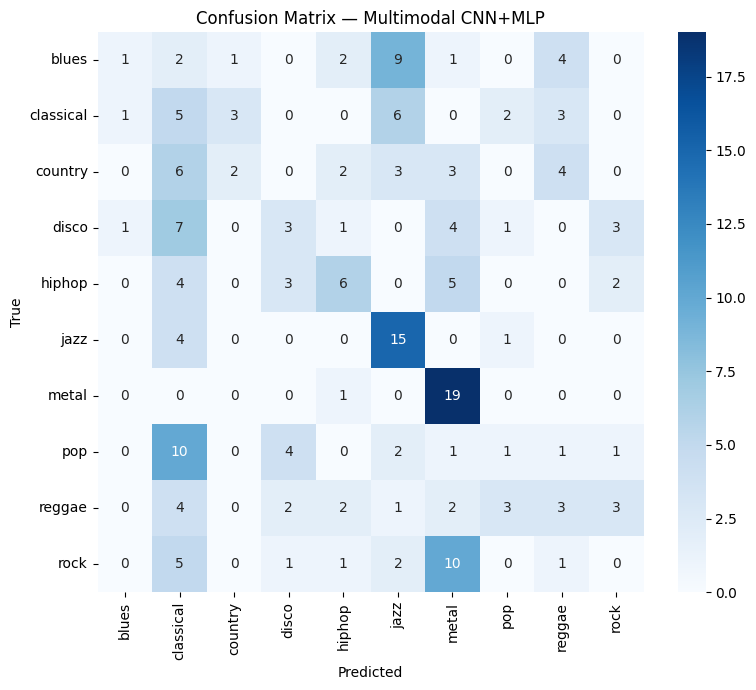

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix
)

# ===== MODIFY THIS LINE: USE THE SCALER =====
X_tab_val_scaled = scaler.transform(X_tab_val_s)

models = {
    "Multimodal CNN+MLP": model,
}

results = []

for name, clf in models.items():
    print(f"\nEvaluating: {name}")
    try:
        if name == "Multimodal CNN+MLP":
            y_pred_probs = clf.predict(
                {"img_input": X_img_val, "tab_input": X_tab_val_scaled},
                verbose=0
            )
        else:
            y_pred_probs = clf.predict_proba(X_tab_val_scaled)

        y_pred = np.argmax(y_pred_probs, axis=1)
    except Exception:
        if name == "Multimodal CNN+MLP":
            y_pred = np.argmax(
                clf.predict({"img_input": X_img_val, "tab_input": X_tab_val_scaled}, verbose=0),
                axis=1
            )
        else:
            y_pred = clf.predict(X_tab_val_scaled)

    acc = accuracy_score(y_val, y_pred)
    f1m = f1_score(y_val, y_pred, average="macro")
    results.append({"Model": name, "Accuracy": acc, "F1 (macro)": f1m})

    print(f"Accuracy: {acc:.4f} | F1 (macro): {f1m:.4f}")
    print(classification_report(y_val, y_pred, target_names=le.classes_, digits=4))

results_df = pd.DataFrame(results).sort_values("Accuracy", ascending=False)
print("\n==================== Summary ====================")
display(results_df.style.format({"Accuracy": "{:.4f}", "F1 (macro)": "{:.4f}"}))

best_name = results_df.iloc[0]["Model"]
print(f"\n🏆 Best performing classifier: {best_name}")

best_model = models[best_name]
if best_name == "Multimodal CNN+MLP":
    y_pred_probs = best_model.predict(
        {"img_input": X_img_val, "tab_input": X_tab_val_scaled}, verbose=0
    )
    y_pred_best = np.argmax(y_pred_probs, axis=1)
else:
    y_pred_best = best_model.predict(X_tab_val_scaled)

cm = confusion_matrix(y_val, y_pred_best)
plt.figure(figsize=(8, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.title(f"Confusion Matrix — {best_name}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [5]:
model.save("music_genre_multimodal.h5")
print("✅ Model saved as 'music_genre_multimodal.h5'")

import joblib
joblib.dump(le, "label_encoder.pkl")
print("✅ Label encoder saved as 'label_encoder.pkl'")

✅ Model saved as 'music_genre_multimodal.h5'
✅ Label encoder saved as 'label_encoder.pkl'


In [6]:
import os

for f in ["music_genre_multimodal.h5", "label_encoder.pkl"]:
    if os.path.exists(f):
        print(f"✅ Found: {f}")
    else:
        print(f"❌ Missing: {f} — check previous cell.")


✅ Found: music_genre_multimodal.h5
✅ Found: label_encoder.pkl


In [7]:
for f in [MODEL_PATH, ENCODER_PATH, SCALER_PATH]:
    print("✅" if os.path.exists(f) else "❌", f)

✅ /content/drive/MyDrive/music_genre_project/music_genre_multimodal.h5
✅ /content/drive/MyDrive/music_genre_project/label_encoder.pkl
✅ /content/drive/MyDrive/music_genre_project/scaler.pkl


In [8]:
%%writefile app.py
import streamlit as st
import numpy as np
import librosa
import librosa.display
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt

# ✅ Load model, encoder, and scaler directly from Google Drive
@st.cache_resource
def load_model():
    MODEL_PATH = "/content/drive/MyDrive/music_genre_project/music_genre_multimodal.h5"
    ENCODER_PATH = "/content/drive/MyDrive/music_genre_project/label_encoder.pkl"
    SCALER_PATH = "/content/drive/MyDrive/music_genre_project/scaler.pkl"

    model = tf.keras.models.load_model(MODEL_PATH)
    le = joblib.load(ENCODER_PATH)
    scaler = joblib.load(SCALER_PATH)
    return model, le, scaler

model, le, scaler = load_model()

# ===== Constants =====
SR = 22050
N_MELS = 128
HOP_LENGTH = 512
N_FFT = 2048
IMG_HEIGHT, IMG_WIDTH = N_MELS, 1280
N_SAMPLES = SR * 30

# ===== Feature Extraction Functions =====
def extract_tabular_features(y, sr=SR):
    S = np.abs(librosa.stft(y, n_fft=N_FFT, hop_length=HOP_LENGTH))
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS,
                                         n_fft=N_FFT, hop_length=HOP_LENGTH)
    logmel = librosa.power_to_db(mel + 1e-6)
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S**2 + 1e-6), sr=sr, n_mfcc=20)
    chroma = librosa.feature.chroma_stft(S=S, sr=sr)
    contrast = librosa.feature.spectral_contrast(S=S, sr=sr)
    centroid = librosa.feature.spectral_centroid(S=S, sr=sr)
    bandwidth = librosa.feature.spectral_bandwidth(S=S, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(S=S, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    try:
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    except Exception:
        tempo = 0.0

    def stats(a):
        a = np.asarray(a)
        return np.array([a.mean(), a.std(), np.median(a), a.min(), a.max()], dtype=np.float32)

    def as1d(x):
        a = np.asarray(x, dtype=np.float32)
        if a.ndim == 0:
            return np.array([a], dtype=np.float32)
        return a.ravel()

    feat_vec = np.hstack([
        stats(logmel),
        as1d(mfcc.mean(axis=1)), as1d(mfcc.std(axis=1)),
        as1d(chroma.mean(axis=1)), as1d(chroma.std(axis=1)),
        as1d(contrast.mean(axis=1)), as1d(contrast.std(axis=1)),
        as1d(centroid.mean()), as1d(centroid.std()),
        as1d(bandwidth.mean()), as1d(bandwidth.std()),
        as1d(rolloff.mean()), as1d(rolloff.std()),
        as1d(zcr.mean()), as1d(zcr.std()),
        as1d(np.float32(tempo))
    ]).astype(np.float32)
    return feat_vec

def extract_spectrogram_image(y, sr=SR):
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS,
                                         n_fft=N_FFT, hop_length=HOP_LENGTH, power=2.0)
    logmel = librosa.power_to_db(mel + 1e-6)
    m, s = logmel.mean(), logmel.std() + 1e-6
    logmel = (logmel - m) / s
    T = logmel.shape[1]
    if T >= IMG_WIDTH:
        start = (T - IMG_WIDTH) // 2
        img = logmel[:, start:start + IMG_WIDTH]
    else:
        pad_left = (IMG_WIDTH - T) // 2
        pad_right = IMG_WIDTH - T - pad_left
        img = np.pad(logmel, ((0, 0), (pad_left, pad_right)), mode="constant")
    return img.astype(np.float32)[..., None]

# ===== Streamlit Interface =====
st.title("🎵 Music Genre Classification")
st.write("Upload an audio file (.wav or .mp3) and the AI will predict its genre!")

uploaded_file = st.file_uploader("Upload audio file", type=["wav", "mp3"])

if uploaded_file is not None:
    y, sr = librosa.load(uploaded_file, sr=SR, mono=True)
    if len(y) < N_SAMPLES:
        y = np.pad(y, (0, N_SAMPLES - len(y)))
    else:
        y = y[:N_SAMPLES]

    st.audio(uploaded_file, format="audio/wav")

    st.subheader("Waveform")
    fig, ax = plt.subplots(figsize=(10, 2))
    librosa.display.waveshow(y, sr=sr, ax=ax)
    st.pyplot(fig)

    st.info("Extracting features...")
    X_tab = extract_tabular_features(y, sr).reshape(1, -1)
    X_img = np.expand_dims(extract_spectrogram_image(y, sr), axis=0)

    # ✅ Scale tabular features before prediction
    X_tab_scaled = scaler.transform(X_tab)

    preds = model.predict({"img_input": X_img, "tab_input": X_tab_scaled})
    genre_idx = np.argmax(preds)
    genre_name = le.inverse_transform([genre_idx])[0]
    confidence = np.max(preds) * 100

    st.success(f"🎶 Predicted Genre: **{genre_name}** ({confidence:.2f}% confidence)")

    st.subheader("Spectrogram")
    fig, ax = plt.subplots(figsize=(10, 4))
    S_dB = librosa.power_to_db(librosa.feature.melspectrogram(y=y, sr=sr), ref=np.max)
    img = librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', ax=ax)
    cbar = plt.colorbar(img, ax=ax, format='%+2.0f dB')
    cbar.set_label("Amplitude (dB)")
    st.pyplot(fig)


Writing app.py


In [9]:
%%writefile requirements.txt
streamlit
tensorflow==2.16.1
librosa==0.10.1
joblib
matplotlib
numpy
scikit-learn


Writing requirements.txt


In [10]:
!npm install -g localtunnel


⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧
added 22 packages in 2s
⠧
⠧3 packages are looking for funding
⠧  run `npm fund` for details
⠧npm notice
npm notice New major version of npm available! 10.8.2 -> 11.6.4
npm notice Changelog: https://github.com/npm/cli/releases/tag/v11.6.4
npm notice To update run: npm install -g npm@11.6.4
npm notice
⠧

In [11]:
!pip install pyngrok --quiet
from pyngrok import ngrok

NGROK_AUTH_TOKEN = "35HEDLm1gcLoEJULFmF3KLwOcLQ_41D12mdkv1Re6W7YjtLYC"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

!nohup streamlit run app.py --server.port 8501 &>/dev/null &

public_url = ngrok.connect(addr="8501", proto="http")
print("✅ Streamlit app is live!")
print("🌐 Public URL:", public_url.public_url)


✅ Streamlit app is live!
🌐 Public URL: https://nontelegraphical-cathey-threateningly.ngrok-free.dev


In [12]:
!ls /content/drive/MyDrive/music_genre_project


label_encoder.pkl  music_genre_multimodal.h5  scaler.pkl
